In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import copy
import ast
import random
import time

In [ ]:
# Set device (for Apple Silicon, use MPS if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

In [2]:
"""
End-to-End Simulation using Simulated Data and an Actual SADE Optimizer for Neural Network Training

This script:
  1. Create synthetic data.
  2. Creates Physical Machines (PMs) and Virtual Machines (VMs) with historical CPU usage.
  3. Trains a feed-forward neural network predictor (to forecast next CPU usage) 
     using a simplified Self-Adaptive Differential Evolution (SADE) optimizer.
  4. Implements three allocation strategies:
       - Random Allocation
       - Reliable Allocation (using current demand)
       - Predictive Allocation (using NN predictions)
  5. Computes metrics (total power, active PM count, system reliability) and produces charts/tables.
"""

'\nEnd-to-End Simulation using Simulated Data and an Actual SADE Optimizer for Neural Network Training\n\nThis script:\n  1. Create synthetic data.\n  2. Creates Physical Machines (PMs) and Virtual Machines (VMs) with historical CPU usage.\n  3. Trains a feed-forward neural network predictor (to forecast next CPU usage) \n     using a simplified Self-Adaptive Differential Evolution (SADE) optimizer.\n  4. Implements three allocation strategies:\n       - Random Allocation\n       - Reliable Allocation (using current demand)\n       - Predictive Allocation (using NN predictions)\n  5. Computes metrics (total power, active PM count, system reliability) and produces charts/tables.\n'

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
# ------------------------------
# Define Classes for PM and VM
# ------------------------------
class VirtualMachine:
    def __init__(self, id, cpu_demand, ram_demand, job_length, history,history_mem=None):
        self.id = id
        self.cpu_demand = cpu_demand      # current CPU demand (units)
        self.ram_demand = ram_demand      # current RAM demand (GB)
        self.job_length = job_length      # length of the job (for reliability calc)
        self.history = history            # historical CPU usage (list of floats)
        self.predicted_cpu = None         # predicted future CPU usage (to be computed)
        self.allocated_pm = None          # PM id after allocation
        self.history_mem = history_mem if history_mem else []

In [5]:
class PhysicalMachine:
    def __init__(self, id, cpu_capacity, ram_capacity, power_max, power_idle, hazard_rate, reliability_score):
        self.id = id
        self.total_cpu = cpu_capacity
        self.avail_cpu = cpu_capacity
        self.total_ram = ram_capacity
        self.avail_ram = ram_capacity
        self.power_max = power_max
        self.power_idle = power_idle
        self.hazard_rate = hazard_rate  # This is used as lambda_max (1/MTBF)
        self.reliability_score = reliability_score  # (not used directly in our new reliability calculation)
        self.allocated_vms = []  # list of VM ids

    def reset(self):
        self.avail_cpu = self.total_cpu
        self.avail_ram = self.total_ram
        self.allocated_vms = []

    def current_utilization(self):
        used_cpu = self.total_cpu - self.avail_cpu
        return used_cpu / self.total_cpu if self.total_cpu > 0 else 0

    def compute_power(self):
        # Power = P_idle + (P_max - P_idle)*utilization, even when no VMs are allocated.
        utilization = self.current_utilization()
        return self.power_idle + (self.power_max - self.power_idle) * utilization

In [6]:
# ------------------------------
# Data Loading Functions
# ------------------------------

In [7]:
def load_borg_data(file_path, scale_factor=10000):
    """
    Load Borg trace data from a CSV file and build VM objects.
    
    For each group (by 'instance_index'):
      - Build a history of CPU usage using the 'random_sample_usage' column.
      - Extract CPU demand from the last history entry (scaled by scale_factor).
      - Extract memory demand from the 'resource_request' column.
      
    Parameters:
      file_path: Path to the Borg trace CSV.
      scale_factor: Factor to scale the raw CPU usage to a realistic unit.
      
    Returns:
      A list of VirtualMachine objects.
    """
    df = pd.read_csv(file_path)
    vms = []
    grouped = df.groupby('instance_index')
    
    for instance, group in grouped:
        history = []
        # Sort by time
        group = group.sort_values(by='time')
        for idx, row in group.iterrows():
            try:
                # Parse random_sample_usage as a dictionary
                usage_val = row['random_sample_usage']
                if isinstance(usage_val, str):
                    usage_dict = ast.literal_eval(usage_val)
                else:
                    usage_dict = usage_val
                cpu_usage = usage_dict.get('cpus', None)
                if cpu_usage is not None:
                    history.append(cpu_usage)
            except Exception as e:
                continue
        
        # Only include VMs with enough history
        if len(history) >= 10:
            # Scale the last CPU usage value to determine demand
            cpu_demand = int(history[-1] * scale_factor)
            # For memory, use the 'resource_request' column:
            try:
                req_val = row['resource_request']
                if isinstance(req_val, str):
                    req_dict = ast.literal_eval(req_val)
                else:
                    req_dict = req_val
                mem_demand = req_dict.get('memory', 1)
            except Exception:
                mem_demand = 1
            
            job_length = (row["end_time"] - row["start_time"]) / 1e6
            # Ensure job_length is positive
            if job_length <= 0:
                job_length = 1
            
            # Create the VM object (assuming VirtualMachine is defined elsewhere)
            vms.append(VirtualMachine(id=f"VM{instance}",
                                      cpu_demand=cpu_demand,
                                      ram_demand=mem_demand,
                                      job_length=job_length,
                                      history=history))
    print(f"Loaded {len(vms)} VMs from the Borg trace.")
    return vms

In [ ]:
def create_synthetic_vms(num_vms=20, history_length=1000,scale_factor=50):
    """
    Create synthetic VMs with generated CPU usage history.
    """
    def generate_synthetic_history(length=10, base=50, noise_level=5):
        t = np.arange(length)
        history = base + 10 * np.sin(2 * np.pi * t / length) + np.random.randn(length) * noise_level
        return np.clip(history, 0, None).tolist()
    
    vms = []
    for i in range(num_vms):
        history = generate_synthetic_history(length=history_length, base=random.uniform(30, 70), noise_level=9)
        cpu_demand = int(history[-1] * scale_factor)
        ram_demand = random.choice([1, 2, 4])  # Randomly choose RAM demand
        job_length = random.uniform(2,5)
        vms.append(VirtualMachine(id=f"VM{i+1}", cpu_demand=cpu_demand, ram_demand=ram_demand, job_length=job_length, history=history))
    return vms

In [9]:
def create_multiple_pms(num_vms):
    # From paper: e.g., 50 VMs use 30 PMs (50/30 ≈ 1.67 VMs per PM)
    # num_pms = max(1, int(np.ceil(num_vms * 0.6)))
    # num_pms = max(1, int(np.ceil(num_vms / 10)))  # e.g., 50 VMs → ~5 PMs, 100 VMs → ~10 PMs, etc.
    num_pms = max(1, int(np.ceil(num_vms / 1.67)))
    pm_list = []
    pm_types = ["S1", "S2", "S3"]
    probabilities = [0.4, 0.3, 0.3]  # Example: 40% S1, 30% S2, 30% S3
    MTBF_S1 = 10   # was 10000
    MTBF_S2 = 12   # was 12000
    MTBF_S3 = 15   # was 8000
    for i in range(num_pms):
        # Randomly choose a PM type among S1, S2, S3 as per paper Table 2.
        pm_type = random.choices(pm_types, weights=probabilities, k=1)[0]
        if pm_type == "S1":
            cpu_capacity = 5320       # in MIPS
            ram_capacity = 4          # in GB
            power_max = 135           # maximum power (e.g., in Watts or scaled units)
            power_idle = 93.7         # idle power
            hazard_rate = 1.0 / MTBF_S1  # tuned so that full utilization yields reliability ~ exp(-0.04*10)=0.67
            reliability_score = 0.80
        elif pm_type == "S2":
            cpu_capacity = 12268
            ram_capacity = 8
            power_max = 113
            power_idle = 42.3
            hazard_rate = 1.0 / MTBF_S2
            reliability_score = 0.70
        elif pm_type == "S3":
            cpu_capacity = 36804
            ram_capacity = 16
            power_max = 222
            power_idle = 58.4
            hazard_rate = 1.0 / MTBF_S3
            reliability_score = 0.90
        pm_list.append(PhysicalMachine(id=f"PM{i+1}", cpu_capacity=cpu_capacity, ram_capacity=ram_capacity,
                                       power_max=power_max, power_idle=power_idle, hazard_rate=hazard_rate,
                                       reliability_score=reliability_score))
    return pm_list

In [10]:
# ------------------------------
# Neural Network Predictor with SADE
# ------------------------------
class UsagePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(UsagePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)   # Use sigmoid activation in hidden layer
        out = self.fc2(out)
        out = self.sigmoid(out)   # Ensure output is in [0,1]
        return out

# Helpers to flatten and set model parameters
def get_flat_params(model):
    params = []
    for p in model.parameters():
        params.append(p.detach().cpu().numpy().flatten())
    return np.concatenate(params)

def set_flat_params(model, flat_vector):
    pointer = 0
    with torch.no_grad():
        for p in model.parameters():
            numel = p.numel()
            new_vals = flat_vector[pointer:pointer+numel]
            new_vals = new_vals.reshape(p.shape)
            p.copy_(torch.from_numpy(new_vals).type_as(p))
            pointer += numel

def fitness_function(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
    # RMSE
    loss = np.sqrt(((outputs.numpy() - y.numpy())**2).mean())
    return loss

def sade_optimizer(model, X, y, population_size=20, generations=50, F=0.5, CR=0.9,mutation_learning_period=10):
    """
    Updated SADE optimizer that randomly selects among four mutation strategies:
      0: DE/best/1
      1: DE/current-to-best/1
      2: DE/rand/1
      3: DE/current-to-rand/1
    """
    base = get_flat_params(model)
    D = base.shape[0]
    population = []
    for i in range(population_size):
        candidate = base + np.random.randn(D) * 0.1
        population.append(candidate)
    
    # Evaluate initial population
    fitness_vals = []
    for cand in population:
        set_flat_params(model, cand)
        fitness_vals.append(fitness_function(model, X, y))
    best_idx = np.argmin(fitness_vals)
    best_solution = population[best_idx].copy()
    best_fitness = fitness_vals[best_idx]
    
    strategies = [0, 1, 2, 3]  # indices for each mutation strategy
    strategy_success = [1, 1, 1, 1]  # Initialize success counts for adaptive strategy selection
    for gen in range(generations):
        new_population = []
        new_fitness_vals = []
        for i in range(population_size):
            # Select a mutation strategy at random (equal probability)
            strategy = random.choices(strategies, weights=strategy_success, k=1)[0]
            indices = list(range(population_size))
            indices.remove(i)
            if strategy == 0:
                # DE/best/1: u_i = best_solution + F*(population[r1] - population[r2])
                r1, r2 = random.sample(indices, 2)
                mutant = best_solution + F * (population[r1] - population[r2])
            elif strategy == 1:
                # DE/current-to-best/1: u_i = population[i] + F*(best_solution - population[i]) + F*(population[r1]-population[r2])
                r1, r2 = random.sample(indices, 2)
                mutant = population[i] + F * (best_solution - population[i]) + F * (population[r1] - population[r2])
            elif strategy == 2:
                # DE/rand/1: u_i = population[r1] + F*(population[r2]-population[r3])
                r1, r2, r3 = random.sample(indices, 3)
                mutant = population[r1] + F * (population[r1] - population[r2])
            elif strategy == 3:
                # DE/current-to-rand/1: u_i = population[i] + F*(population[r1] - population[i]) + F*(population[r2]-population[r3])
                r1, r2, r3 = random.sample(indices, 3)
                # mutant = population[i] + F * (population[r1] - population[i]) + F * (population[r2] - population[r3])
                k_i = random.random()  # or any strategy to set k_i
                mutant = population[i] + k_i * (population[r1] - population[i]) + F * (population[r2] - population[r3])
            
            # Uniform crossover
            trial = population[i].copy()
            for j in range(D):
                if random.random() < CR:
                    trial[j] = mutant[j]
            
            # Selection step: if trial has lower RMSE, accept it
            set_flat_params(model, trial)
            fit_trial = fitness_function(model, X, y)
            if fit_trial < fitness_vals[i]:
                new_population.append(trial)
                new_fitness_vals.append(fit_trial)
                strategy_success[strategy] += 1
            else:
                new_population.append(population[i])
                new_fitness_vals.append(fitness_vals[i])
        
        population = new_population
        fitness_vals = new_fitness_vals
        current_best_idx = np.argmin(fitness_vals)
        if fitness_vals[current_best_idx] < best_fitness:
            best_solution = population[current_best_idx].copy()
            best_fitness = fitness_vals[current_best_idx]
            
        # Every mutation_learning_period generations, adapt F and CR
        if (gen + 1) % mutation_learning_period == 0:
            # Apply a small random perturbation (±5%) and ensure values remain within [0.1, 1.0]
            F = max(0.1, min(1.0, F * (1 + 0.05 * (np.random.rand() - 0.5))))
            CR = max(0.1, min(1.0, CR * (1 + 0.05 * (np.random.rand() - 0.5))))
            # Reset strategy success counts for a fresh start
            strategy_success = [1, 1, 1, 1]
        print(f"Generation {gen+1}, Best RMSE: {best_fitness:.6f}")
    
    # Set model to best found solution
    set_flat_params(model, best_solution)
    return model

def train_predictor_with_split(vms, input_window=1000, hidden_size=10, generations=50, population_size=20, F=0.5, CR=0.9, train_ratio=0.75):
    # Prepare raw data from all VM histories
    X_list = []
    y_list = []
    print(f"Preparing data for {len(vms)} VMs...")
    for vm in vms:
        hist = vm.history
        if len(hist) < input_window + 1:
            continue
        for i in range(len(hist) - input_window):
            X_list.append(hist[i:i+input_window])
            y_list.append(hist[i+input_window])
    print(f"Data prepared: {len(X_list)} samples.")
    X_all = np.array(X_list, dtype=np.float32)
    y_all = np.array(y_list, dtype=np.float32).reshape(-1, 1)
    
    # Normalize the data per Equation (11)
    D_min = X_all.min()
    D_max = X_all.max()
    X_norm = (X_all - D_min) / (D_max - D_min + 1e-8)
    y_norm = (y_all - D_min) / (D_max - D_min + 1e-8)
    
    indices = np.arange(len(X_norm))
    np.random.shuffle(indices)
    split_index = int(train_ratio * len(indices))
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    X_train = torch.from_numpy(X_norm[train_indices])
    y_train = torch.from_numpy(y_norm[train_indices])
    X_test = torch.from_numpy(X_norm[test_indices])
    y_test = torch.from_numpy(y_norm[test_indices])
    
    input_size = input_window
    model = UsagePredictor(input_size=input_size, hidden_size=hidden_size)
    print("Starting SADE optimization for the predictor...")
    model = sade_optimizer(model, X_train, y_train, population_size=population_size, generations=generations, F=F, CR=CR)
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
    test_rmse = np.sqrt(((outputs.numpy() - y_test.numpy())**2).mean())
    test_mae = np.abs((outputs.numpy() - y_test.numpy())).mean()
    print(f"Test RMSE (normalized): {test_rmse:.6f}")
    print(f"Test MAE (normalized): {test_mae:.6f}")
    
    # Return model, RMSE, MAE, and normalization parameters
    return model, test_rmse, test_mae, D_min, D_max

def predict_vm_usage(model, vm, input_window=1000, D_min=0, D_max=1):
    if len(vm.history) < input_window:
        return vm.cpu_demand
    # Normalize the input using stored D_min and D_max
    input_data = np.array(vm.history[-input_window:], dtype=np.float32)
    input_norm = (input_data - D_min) / (D_max - D_min + 1e-8)
    input_tensor = torch.from_numpy(input_norm).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        predicted_norm = model(input_tensor).item()
    # Denormalize the prediction
    predicted = predicted_norm * (D_max - D_min) + D_min
    return predicted

In [11]:
# ------------------------------
# Allocation Strategies
# ------------------------------
def reset_pms(pms:list[PhysicalMachine]):
    for pm in pms:
        pm.reset()

def ffd_allocation(vms, pms):
    # Get list of VMs that were not allocated in the random allocation phase
    unallocated = [vm for vm in vms if vm.allocated_pm is None]
    # Sort the unallocated VMs in decreasing order of cpu_demand
    unallocated.sort(key=lambda vm: vm.cpu_demand, reverse=True)
    # Optionally, sort PMs in descending order of available CPU
    sorted_pms = sorted(pms, key=lambda pm: pm.avail_cpu, reverse=True)
    for vm in unallocated:
        for pm in sorted_pms:
            if vm.cpu_demand <= pm.avail_cpu and vm.ram_demand <= pm.avail_ram:
                pm.avail_cpu -= vm.cpu_demand
                pm.avail_ram -= vm.ram_demand
                pm.allocated_vms.append(vm.id)
                vm.allocated_pm = pm.id
                break
            
def random_allocation(vms, pms):
    allocation = {}
    random.shuffle(vms)
    for vm in vms:
        allocated = False
        random_pms = pms.copy()
        random.shuffle(random_pms)
        for pm in random_pms:
            if vm.cpu_demand <= pm.avail_cpu and vm.ram_demand <= pm.avail_ram:
                pm.avail_cpu -= vm.cpu_demand
                pm.avail_ram -= vm.ram_demand
                pm.allocated_vms.append(vm.id)
                vm.allocated_pm = pm.id
                allocation[vm.id] = pm.id
                allocated = True
                break
        if not allocated:
            allocation[vm.id] = None
    # After initial random allocation, apply FFD to assign unallocated VMs
    ffd_allocation(vms, pms)
    return {vm.id: vm.allocated_pm for vm in vms}

def reliable_allocation(vms, pms, use_prediction=False, max_utilization=0.75):
    allocation = {}
    # Sort PMs by reliability_score (or by available resources)
    sorted_pms = sorted(pms, key=lambda x: x.current_utilization())
    for vm in vms:
        demand = vm.predicted_cpu if (use_prediction and vm.predicted_cpu is not None) else vm.cpu_demand
        allocated = False
        for pm in sorted_pms:
            used_cpu = pm.total_cpu - pm.avail_cpu
            # Only allocate if adding this VM will not exceed max utilization
            # if (pm.avail_cpu - demand) >= pm.total_cpu * (1 - max_utilization) and vm.ram_demand <= pm.avail_ram:
            if (vm.cpu_demand + used_cpu) <= pm.total_cpu and vm.ram_demand <= pm.avail_ram:
            # if demand <= pm.avail_cpu and vm.ram_demand <= pm.avail_ram:
                pm.avail_cpu -= demand
                pm.avail_ram -= vm.ram_demand
                pm.allocated_vms.append(vm.id)
                vm.allocated_pm = pm.id
                allocation[vm.id] = pm.id
                allocated = True
                break
        if not allocated:
            allocation[vm.id] = None
    return allocation

In [20]:
# ------------------------------
# Metrics Calculation
# ------------------------------
def compute_total_power(pms):
    return sum(pm.compute_power() for pm in pms)

def count_active_pms(pms):
    return sum(1 for pm in pms if len(pm.allocated_vms) > 0)

def compute_system_reliability(vms, pms, beta=3.0):
    """
    Paper-style server-based reliability:
      - For each PM: Reliability_server = Π (over VMs on that PM) of exp( - λ_ij * job_length )
      - λ_ij = (base_hazard_rate) * (utilization^beta)
      - Then system reliability = product of all PM reliabilities

    :param vms: list[VirtualMachine]
    :param pms: list[PhysicalMachine]
    :param beta: exponent for scaling hazard rate by utilization
    """
    # Build a VM dictionary for quick lookup
    vm_dict = {vm.id: vm for vm in vms}

    total_system_rel = 1.0
    for pm in pms:
        if len(pm.allocated_vms) == 0:
            # No effect if no VMs allocated
            continue

        # Compute server-level reliability
        utilization = pm.current_utilization()
        # scale hazard rate by utilization^beta
        scaled_hazard = pm.hazard_rate * (utilization ** beta)
        

        server_rel = 1.0
        for vm_id in pm.allocated_vms:
            vm = vm_dict[vm_id]
            effective_job_length = vm.job_length * 2.0
            r_vm = math.exp(-scaled_hazard * effective_job_length)
            server_rel *= r_vm

        total_system_rel *= server_rel

    return total_system_rel

In [13]:
# ------------------------------
# GA-based Multi-Objective Allocation
# ------------------------------
def evaluate_allocation(individual, vms, pms, beta, weight_power, weight_rel, lambda_active=0.2):
    # Reset all PMs and allocate VMs according to the individual mapping.
    for pm in pms:
        pm.reset()
        
    for i, pm_idx in enumerate(individual):
        if pm_idx < 0 or pm_idx >= len(pms):
            continue
        pm = pms[pm_idx]
        vm = vms[i]
        pm.avail_cpu -= vm.cpu_demand
        pm.avail_ram -= vm.ram_demand
        pm.allocated_vms.append(vm.id)
        vm.allocated_pm = pm.id

    # Enforce a heavy penalty if any PM is over capacity.
    penalty = 0
    for pm in pms:
        if pm.avail_cpu < 0:
            penalty += abs(pm.avail_cpu) * 500
        if pm.avail_ram < 0:
            penalty += abs(pm.avail_ram) * 500

    # Compute normalized power consumption.
    total_power = sum(pm.compute_power() for pm in pms)
    sum_idle = sum(pm.power_idle for pm in pms)
    sum_max = sum(pm.power_max for pm in pms)
    norm_power = (total_power - sum_idle) / (sum_max - sum_idle + 1e-8)

    pms_dict = {pm.id: pm for pm in pms}
    avg_rel = compute_system_reliability(vms, pms, beta=beta)
    
    # NEW: Calculate normalized active PM count.
    active_pm_count = count_active_pms(pms)
    norm_active = active_pm_count / len(pms)
    
    # Objective: minimize weighted normalized power + weight for (1 - reliability) + penalty.
    obj = weight_power * norm_power + weight_rel * (1 - avg_rel) + lambda_active * norm_active + penalty
    return obj

def ga_multi_objective_allocation(vms, pms, beta=3.0, pop_size=50, generations=100, weight_power=0.5, weight_rel=0.5, mutation_rate=0.1, crossover_rate=0.8):
    num_vms = len(vms)
    num_pms = len(pms)
    population = [[random.randint(0, num_pms-1) for _ in range(num_vms)] for _ in range(pop_size)]
    
    fitness = []
    for individual in population:
        pms_copy = copy.deepcopy(pms)
        fit = evaluate_allocation(individual, vms, pms_copy, beta, weight_power, weight_rel)
        fitness.append(fit)
    
    for gen in range(generations):
        new_population = []
        new_fitness = []
        for _ in range(pop_size):
            i1, i2 = random.sample(range(pop_size), 2)
            parent1 = population[i1] if fitness[i1] < fitness[i2] else population[i2]
            i1, i2 = random.sample(range(pop_size), 2)
            parent2 = population[i1] if fitness[i1] < fitness[i2] else population[i2]
            
            if random.random() < crossover_rate:
                point = random.randint(1, num_vms - 1)
                child = parent1[:point] + parent2[point:]
            else:
                child = parent1.copy()
            
            for j in range(num_vms):
                if random.random() < mutation_rate:
                    child[j] = random.randint(0, num_pms - 1)
            
            pms_copy = copy.deepcopy(pms)
            child_fit = evaluate_allocation(child, vms, pms_copy, beta, weight_power, weight_rel)
            new_population.append(child)
            new_fitness.append(child_fit)
        
        combined = population + new_population
        combined_fitness = fitness + new_fitness
        sorted_indices = sorted(range(len(combined)), key=lambda i: combined_fitness[i])
        population = [combined[i] for i in sorted_indices[:pop_size]]
        fitness = [combined_fitness[i] for i in sorted_indices[:pop_size]]
        # print(f"GA Generation {gen+1}, Best Objective: {fitness[0]:.6f}")
    
    best_allocation = population[0]
    return best_allocation, fitness[0]

In [14]:
def plot_predicted_vs_actual_cpu(vm, predictor, input_window, D_min, D_max):
    # Generate predictions using a sliding window over the VM's history
    actual = vm.history
    predicted = []
    for i in range(len(actual) - input_window):
        window = np.array(actual[i:i+input_window], dtype=np.float32)
        window_norm = (window - D_min) / (D_max - D_min + 1e-8)
        input_tensor = torch.from_numpy(window_norm).unsqueeze(0)
        predictor.eval()
        with torch.no_grad():
            pred_norm = predictor(input_tensor).item()
        pred = pred_norm * (D_max - D_min) + D_min
        predicted.append(pred)
    plt.figure(figsize=(8,4))
    plt.plot(range(input_window, len(actual)), actual[input_window:], label="Actual CPU Usage")
    plt.plot(range(input_window, len(actual)), predicted, label="Predicted CPU Usage", linestyle="--")
    plt.xlabel("Time Step")
    plt.ylabel("CPU Usage")
    plt.title(f"Predicted vs Actual CPU Usage for {vm.id}")
    plt.legend()
    plt.show()

In [26]:
def run_dynamic_consolidation(vms, pms, predictor, time_steps=5, D_min=0, D_max=100, beta=3.0):
    """
    Example multi-period scenario:
      - Repeatedly update each VM's usage (predicted or random).
      - Re-allocate or consolidate at each step.
      - Track power + reliability over time.
    """
    # First: do an initial allocation
    reset_pms(pms)
    for vm in vms:
        vm.allocated_pm = None
    
    # Initial allocation
    reliable_allocation(vms, pms, use_prediction=True)
    results = []

    for t in range(time_steps):
        # measure
        total_power = compute_total_power(pms)
        system_rel = compute_system_reliability(vms, pms, beta=beta)
        active_pms_count = count_active_pms(pms)

        results.append({
            "time": t,
            "Power": total_power,
            "Reliability": system_rel,
            "ActivePMs": active_pms_count
        })

        # Update each VM's usage for the next step
        # For instance, use your predictor to forecast new CPU usage
        for vm in vms:
            predicted_val = predict_vm_usage(predictor, vm, input_window=500, D_min=D_min, D_max=D_max)
            # shift the window by appending new usage & removing oldest
            vm.history.pop(0)
            vm.history.append(predicted_val)
            # Convert predicted CPU to int
            vm.cpu_demand = max(1, int(predicted_val))

        # "Reallocate" or "migrate"
        reset_pms(pms)
        for vm in vms:
            vm.allocated_pm = None
        # Use the predictor to guide the allocation
        reliable_allocation(vms, pms, use_prediction=True)
    
    return pd.DataFrame(results)

In [16]:
full_vms = create_synthetic_vms(num_vms=5000, history_length=800,scale_factor=100)

In [17]:
predictor, test_rmse, test_mae, D_min, D_max = train_predictor_with_split(full_vms,
                                                                          input_window=500,
                                                                          hidden_size=30,
                                                                        generations=50,
                                                                        population_size=30,
                                                                        F=0.5, CR=0.9,
                                                                      train_ratio=0.75)
print(f"Trained predictor once; Test RMSE (normalized): {test_rmse:.6f}")

Preparing data for 5000 VMs...
Data prepared: 1500000 samples.
Starting SADE optimization for the predictor...
Generation 1, Best RMSE: 0.133545
Generation 2, Best RMSE: 0.127883
Generation 3, Best RMSE: 0.115002
Generation 4, Best RMSE: 0.105454
Generation 5, Best RMSE: 0.096885
Generation 6, Best RMSE: 0.096743
Generation 7, Best RMSE: 0.079694
Generation 8, Best RMSE: 0.079694
Generation 9, Best RMSE: 0.078700
Generation 10, Best RMSE: 0.073629
Generation 11, Best RMSE: 0.073629
Generation 12, Best RMSE: 0.072499
Generation 13, Best RMSE: 0.071759
Generation 14, Best RMSE: 0.071759
Generation 15, Best RMSE: 0.071108
Generation 16, Best RMSE: 0.069957
Generation 17, Best RMSE: 0.067978
Generation 18, Best RMSE: 0.065783
Generation 19, Best RMSE: 0.063805
Generation 20, Best RMSE: 0.063805
Generation 21, Best RMSE: 0.060540
Generation 22, Best RMSE: 0.059577
Generation 23, Best RMSE: 0.058415
Generation 24, Best RMSE: 0.057883
Generation 25, Best RMSE: 0.057813
Generation 26, Best RMS

In [27]:
# ------------------------------
# Combined Grid Search and Simulation
# ------------------------------
def run_full_grid_search_simulation(scales=[50, 100, 200, 400, 600, 800, 1000, 1200, 1600], beta=3.0,):
    results = []
    
    for num_vms in scales:
        print(f"\nRunning simulation for {num_vms} VMs:")
        
        # Use the pre-trained predictor to assign predicted CPU usage for each VM.
        for vm in full_vms:
            vm.predicted_cpu = predict_vm_usage(predictor, vm, input_window=500, D_min=D_min, D_max=D_max)
        
        # Run allocation strategies:
        # Generate a realistic number of PMs based on VM count.
        base_pms = create_multiple_pms(num_vms)
        
        # (a) Random Allocation
        pms1 = copy.deepcopy(base_pms)
        for vm in full_vms:
            vm.allocated_pm = None
        start_time = time.time()
        random_allocation(full_vms, pms1)
        power_random = compute_total_power(pms1)
        active_random = count_active_pms(pms1)
        end_time = time.time()
        rel_random = compute_system_reliability(full_vms, pms1, beta=beta)
        results.append({"VMs": num_vms, "Algorithm": "Random", "Total Power": power_random,
                        "Active PMs": active_random, "Reliability": rel_random, "Test RMSE": test_rmse,"Exec. time (ms)": (end_time - start_time)*1000})
        
        # (b) Reliable Allocation (Current Demand)
        pms2 = copy.deepcopy(base_pms)
        pms2_dict = {pm.id: pm for pm in pms2}
        reset_pms(pms2)
        for vm in full_vms:
            vm.allocated_pm = None
        start_time = time.time()
        reliable_allocation(full_vms, pms2, use_prediction=False)
        end_time = time.time()
        power_rel_current = compute_total_power(pms2)
        active_rel_current = count_active_pms(pms2)
        rel_rel_current = compute_system_reliability(full_vms, pms2, beta=beta)
        results.append({"VMs": num_vms, "Algorithm": "Reliable_Current", "Total Power": power_rel_current,
                        "Active PMs": active_rel_current, "Reliability": rel_rel_current, "Test RMSE": test_rmse,"Exec. time (ms)": (end_time - start_time)*1000})
        
        # (c) Predictive Allocation (Using NN Predictions)
        pms3 = copy.deepcopy(base_pms)
        reset_pms(pms3)
        for vm in full_vms:
            vm.allocated_pm = None
        start_time= time.time()
        # reliable_allocation(vms, pms3, use_prediction=True)
        df_dyn = run_dynamic_consolidation(full_vms, pms3, predictor, time_steps=500, D_min=D_min, D_max=D_max, beta=2.0)
        final_step = df_dyn.iloc[-1]  # last row
        end_time= time.time()
        results.append({"VMs": num_vms, "Algorithm": "Predictive", "Total Power": final_step["Power"],
                        "Active PMs": final_step["ActivePMs"], "Reliability": final_step["Reliability"], "Test RMSE": test_rmse,"Exec. time (ms)": (end_time - start_time)*1000})
        
        # (d) GA-based Multi-Objective Allocation
        pms4 = copy.deepcopy(base_pms)
        reset_pms(pms4)
        for vm in full_vms:
            vm.allocated_pm = None
        start_time = time.time()
        best_alloc, best_obj = ga_multi_objective_allocation(full_vms, pms4, beta=beta, pop_size=50,
                                                             generations=100, weight_power=0.5, weight_rel=0.5)
        end_time = time.time()
        for i, pm_idx in enumerate(best_alloc):
            vm = full_vms[i]
            pms4[pm_idx].avail_cpu -= vm.cpu_demand
            pms4[pm_idx].avail_ram -= vm.ram_demand
            pms4[pm_idx].allocated_vms.append(vm.id)
            vm.allocated_pm = pms4[pm_idx].id
        power_ga = compute_total_power(pms4)
        active_ga = count_active_pms(pms4)
        rel_ga = compute_system_reliability(full_vms, pms4, beta=beta)
        results.append({"VMs": num_vms, "Algorithm": "GA_MultiObjective", "Total Power": power_ga,
                        "Active PMs": active_ga, "Reliability": rel_ga, "Test RMSE": test_rmse,"Exec. time (ms)": (end_time - start_time)*1000, "Objective": best_obj})
    
    df_results = pd.DataFrame(results)
    print("\nGrid Search Results:")
    print(df_results)
    return df_results,predictor, test_rmse, D_min, D_max


Running simulation for 50 VMs:

Running simulation for 100 VMs:

Running simulation for 200 VMs:

Running simulation for 400 VMs:

Running simulation for 600 VMs:

Running simulation for 800 VMs:

Running simulation for 1000 VMs:

Running simulation for 1200 VMs:

Running simulation for 1600 VMs:

Grid Search Results:
     VMs          Algorithm   Total Power  Active PMs    Reliability  \
0     50             Random   4345.811002        30.0   1.561308e-18   
1     50   Reliable_Current   4341.283078        30.0   2.056089e-19   
2     50         Predictive   1909.802979        30.0   9.855292e-01   
3     50  GA_MultiObjective   3312.689345        30.0   0.000000e+00   
4    100             Random   4055.802734        60.0   9.993097e-01   
5    100   Reliable_Current   4051.781560        60.0   9.995871e-01   
6    100         Predictive   4052.573730        60.0   9.763667e-01   
7    100  GA_MultiObjective   5479.260539        60.0  3.429865e-148   
8    200             Random   8

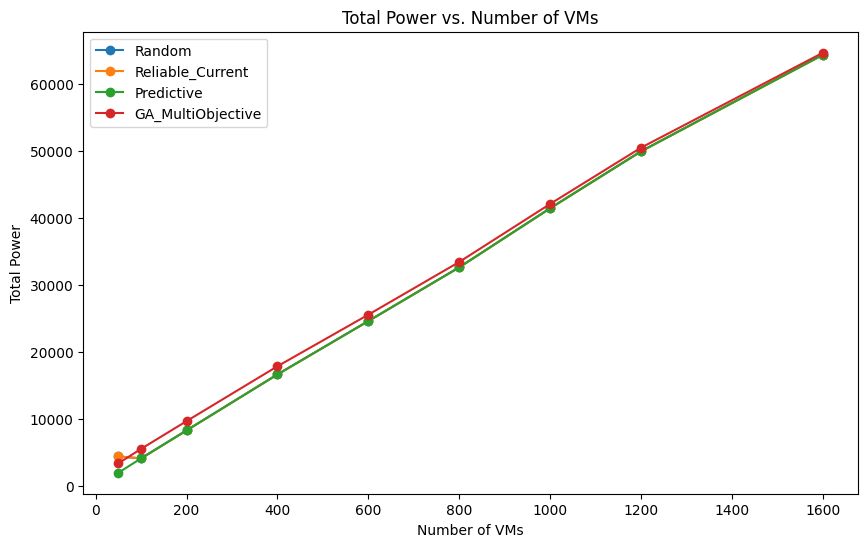

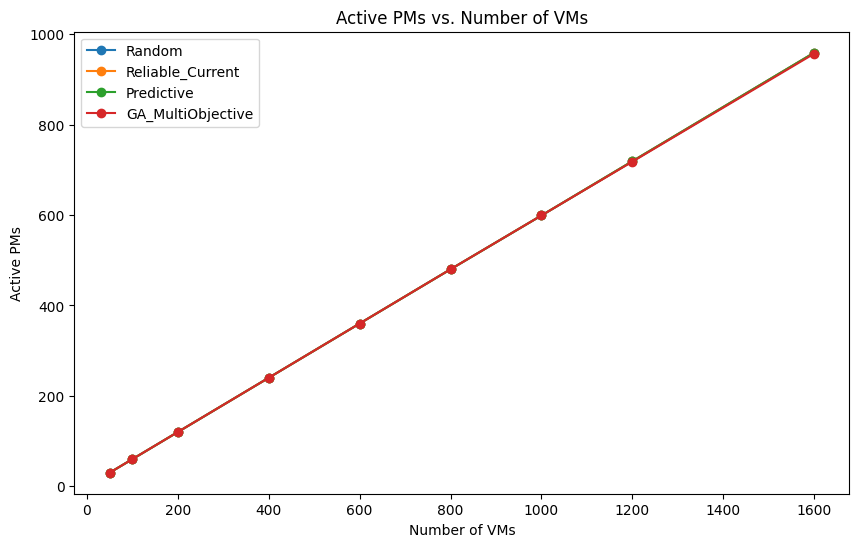

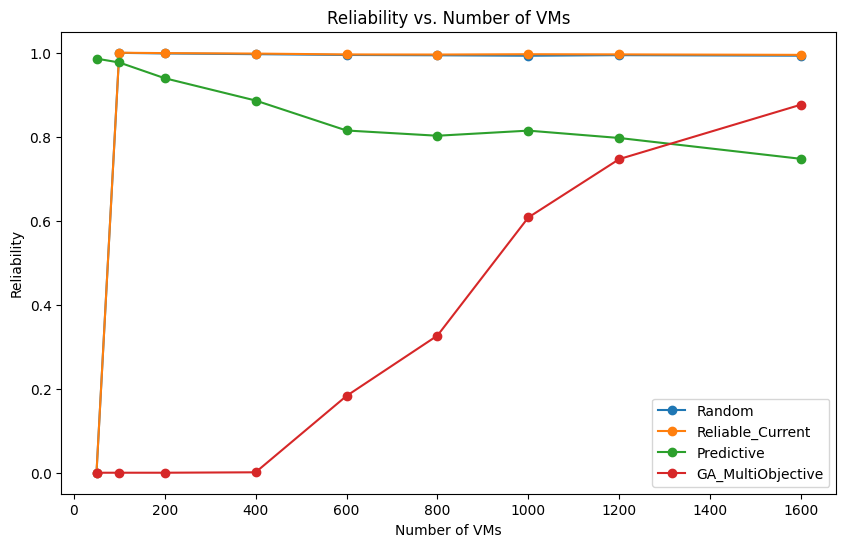

In [28]:
# ------------------------------
# Main Simulation Function
# ------------------------------

scales = [50, 100, 200, 400, 600, 800, 1000, 1200, 1600]
grid_results,predictor, test_rmse, D_min, D_max = run_full_grid_search_simulation(scales=scales,beta=3.0)

# Visualization of results for each metric across algorithms.
algorithms = grid_results["Algorithm"].unique()
for metric in ["Total Power", "Active PMs", "Reliability"]:
    plt.figure(figsize=(10, 6))
    for algo in algorithms:
        subset = grid_results[grid_results["Algorithm"] == algo]
        plt.plot(subset["VMs"], subset[metric], marker='o', label=algo)
    plt.xlabel("Number of VMs")
    plt.ylabel(metric)
    plt.title(f"{metric} vs. Number of VMs")
    plt.legend()
    plt.show()   

In [29]:
D_min

np.float32(9.433134)

In [30]:
D_max

np.float32(90.067924)

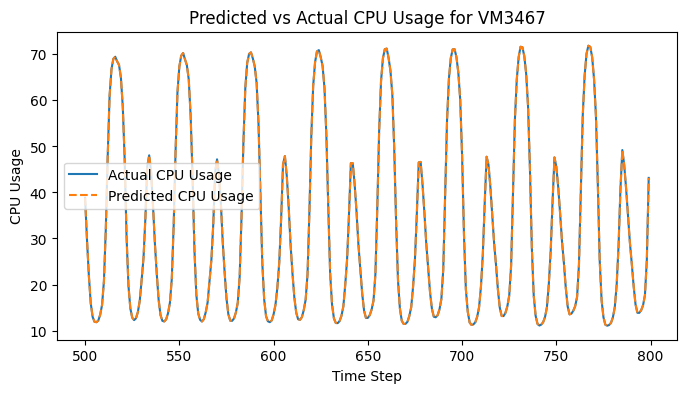

In [31]:
plot_predicted_vs_actual_cpu(full_vms[500], predictor, input_window=500, D_min=D_min, D_max=D_max)